# Face detection

## Checking data

### Import 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_csv("E:/data/facial-keypoints-detection/training.csv")
train_data.shape

(7049, 31)

In [3]:
train_data.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


In [4]:
train_data.isna().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

In [5]:
# fill miss data
train_data.fillna(method='ffill', inplace=True)

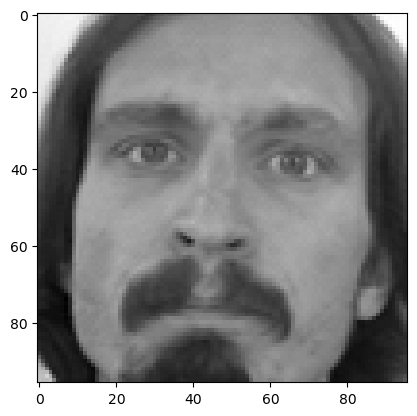

In [6]:
plt.imshow(np.array(train_data['Image'][0].split(
    ' '), dtype='float').reshape(96, 96), cmap='gray')

In [7]:
img_dt = []
for i in range(len(train_data)):
    img_dt.append(train_data['Image'][i].split(' '))

X = np.array(img_dt, dtype='float')

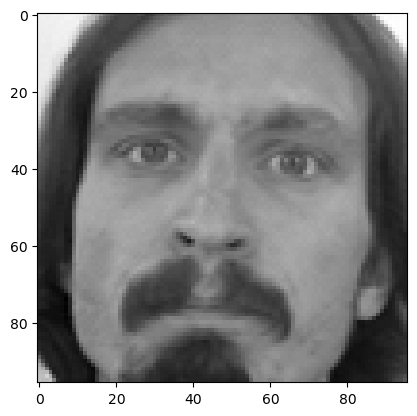

In [8]:
plt.imshow(X[0].reshape(96, 96), cmap='gray')

In [9]:
facial_pts_data = train_data.drop(['Image'], axis=1)
facial_pts = []

for i in range(len(facial_pts_data)):
    facial_pts.append(facial_pts_data.iloc[i])

y = np.array(facial_pts, dtype='float')

In [10]:
y[0]

array([66.03356391, 39.00227368, 30.22700752, 36.4216782 , 59.58207519,
       39.64742256, 73.13034586, 39.96999699, 36.35657143, 37.3894015 ,
       23.45287218, 37.3894015 , 56.95326316, 29.03364812, 80.22712782,
       32.22813835, 40.22760902, 29.0023218 , 16.35637895, 29.64747068,
       44.42057143, 57.06680301, 61.19530827, 79.97016541, 28.61449624,
       77.38899248, 43.3126015 , 72.93545865, 43.13070677, 84.48577444])

In [11]:
import torch
from torch import nn, optim
import torch.nn.functional as F

In [12]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # (b,1,96,96) to (b,4,92,92)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5)
        self.conv1_bn = nn.BatchNorm2d(4)
        # (b,4,46,46) to (b,64,44,44)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=64, kernel_size=3)
        self.conv2_bn = nn.BatchNorm2d(64)
        # (b,64,22,22) to (b,128,20,20)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.conv3_bn = nn.BatchNorm2d(128)
        # (b,128,10,10) to (b,256,8,8)
        self.conv4 = nn.Conv2d(
            in_channels=128, out_channels=256, kernel_size=3)
        self.conv4_bn = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256*4*4, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 30)
        self.dp1 = nn.Dropout(p=0.4)

    def forward(self, x, verbose=False):
        # apply conv1, relu and maxpool2d
        x = self.conv1_bn(self.conv1(x))
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dp1(x)

        # apply conv2, relu and maxpool2d
        x = self.conv2_bn(self.conv2(x))
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dp1(x)

        # apply conv3, relu and maxpool2d
        x = self.conv3_bn(self.conv3(x))
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dp1(x)

        # apply conv4, relu and maxpool2d
        x = self.conv4_bn(self.conv4(x))
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # apply dropout
        x = self.dp1(x)

        x = x.view(-1, 256*4*4)

        # now use FC layer with relu
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp1(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dp1(x)
        x = self.fc3(x)
        return x

In [13]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(device)

cuda


In [14]:
def test(model, device, valid_loader):
    model.eval()
    test_loss = 0
    for X, y in valid_loader:
        X, y = X.to(device), y.to(device)
        X = X.view(-1, 96*96)
        X = X.view(-1, 1, 96, 96)
        output = model(X)
        loss = criterion(output, y)
        test_loss += loss.item()

    test_loss = test_loss/len(valid_loader.dataset)
    return test_loss


def fit(epochs, model, criterion, device, train_loader, valid_loader, optimizer):
    train_loss_list = []
    val_loss_list = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_idx, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)
            X = X.view(-1, 96*96)
            X = X.view(-1, 1, 96, 96)
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, y)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()

        train_loss = train_loss/len(train_loader.dataset)
        eval_loss = test(model, device, valid_loader)
        train_loss_list.append(train_loss)
        val_loss_list.append(eval_loss)
        if (epoch+1) % 25 == 0:
            print("End of epoch {}: \nTraining error = [{}]\tValidation error = [{}]".format(
                epoch+1, train_loss, eval_loss))
    return train_loss_list, val_loss_list

In [15]:
import torch.utils.data as data_utils
from torch.utils.data.sampler import SubsetRandomSampler


def train_test_split(X, validation_split):
    dataset_size = len(X)
    indices = list(range(dataset_size))
    val_num = int(np.floor(validation_split*dataset_size))
    np.random.shuffle(indices)
    train_indices, test_indices = indices[val_num:], indices[:val_num]

    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(test_indices)

    loader_obj = data_utils.TensorDataset(
        torch.from_numpy(X).float(), torch.from_numpy(y).float())
    train_loader = data_utils.DataLoader(
        loader_obj, batch_size=8, sampler=train_sampler)
    valid_loader = data_utils.DataLoader(
        loader_obj, batch_size=8, sampler=valid_sampler)

    return train_loader, valid_loader

In [16]:
def get_n_params(model):
    np = 0
    for p in list(model.parameters()):
        np += p.nelement()
    return np


n_hidden = 128  # number of hidden units
output_size = 30
train_loader, valid_loader = train_test_split(X, 0.2)

model = CNN()
model.to(device)
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters())

print('Number of parameters: {}'.format(get_n_params(model)))

train_error_list, valid_error_list = fit(
    500, model, criterion, device, train_loader, valid_loader, optimizer)

Number of parameters: 4837838
End of epoch 25: 
Training error = [4.699664973252072]	Validation error = [0.8953684464399316]
End of epoch 50: 
Training error = [2.0413062335379766]	Validation error = [0.19498082863927682]
End of epoch 75: 
Training error = [1.4700794296410764]	Validation error = [0.16556508832999978]
End of epoch 100: 
Training error = [1.3179924913899648]	Validation error = [0.15844556674464813]
End of epoch 125: 
Training error = [1.2402152443189185]	Validation error = [0.15430196399704957]
End of epoch 150: 
Training error = [1.1402291889680432]	Validation error = [0.15813750190115225]
End of epoch 175: 
Training error = [1.03365767974518]	Validation error = [0.1727903122799771]
End of epoch 200: 
Training error = [0.9641030356974987]	Validation error = [0.14511768894679902]
End of epoch 225: 
Training error = [0.9244225641432714]	Validation error = [0.15441066007239376]
End of epoch 250: 
Training error = [0.8415318482107161]	Validation error = [0.1594161545406725]

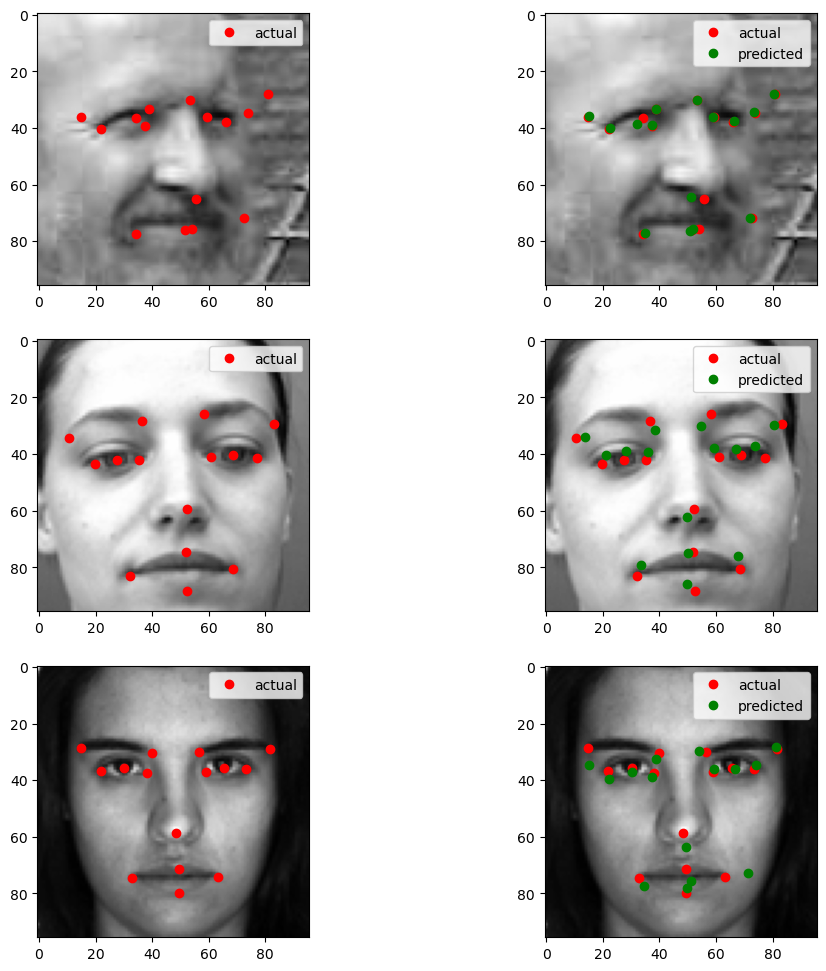

In [17]:
def plot_samples(X, y, model, num_samples):
    fig, axes = plt.subplots(nrows=num_samples, ncols=2, figsize=(12, 12))

    for row in range(num_samples):
        sample_idx = np.random.choice(len(X))
        x = X[sample_idx]
        x = torch.from_numpy(x).float().view(1, 1, 96, 96).to(device)
        actual_y = y[sample_idx]
        pred_y = model(x)
        img = X[sample_idx].reshape(96, 96)

        actual_y = np.vstack(np.split(actual_y, 15)).T
        pred_y = pred_y.cpu().data.numpy()[0]
        pred_y = np.vstack(np.split(pred_y, 15)).T

        axes[row, 0].imshow(img, cmap='gray')
        axes[row, 0].plot(actual_y[0], actual_y[1], 'o',
                          color='red', label='actual')
        axes[row, 0].legend()
        axes[row, 1].imshow(img, cmap='gray')
        axes[row, 1].plot(actual_y[0], actual_y[1], 'o',
                          color='red', label='actual')
        axes[row, 1].plot(pred_y[0], pred_y[1], 'o',
                          color='green', label='predicted')
        axes[row, 1].legend()


plot_samples(X, y, model, 3)

In [19]:
test_data = pd.read_csv("E:/data/facial-keypoints-detection/test.csv")

img_dt = []

for i in range(len(test_data)):
    img_dt.append(test_data['Image'][i].split(' '))

test_X = np.array(img_dt, dtype='float')

In [20]:
test_X_torch = torch.from_numpy(test_X).float().view(
    len(test_X), 1, 96, 96).to(device)
test_predictions = model(test_X_torch)
test_predictions = test_predictions.cpu().data.numpy()

keypts_labels = train_data.columns.tolist()

RuntimeError: CUDA out of memory. Tried to allocate 176.00 MiB (GPU 0; 6.00 GiB total capacity; 5.17 GiB already allocated; 0 bytes free; 5.20 GiB reserved in total by PyTorch)

In [ ]:
def plot_samples_test(X, y, num_samples):
    fig, axes = plt.subplots(nrows=1, ncols=num_samples, figsize=(20, 12))

    for row in range(num_samples):
        sample_idx = np.random.choice(len(X))
        img = X[sample_idx].reshape(96, 96)
        predicted = y[sample_idx]

        predicted = np.vstack(np.split(predicted, 15)).T
#     print(img, predicted)
        axes[row].imshow(img, cmap='gray')
        axes[row].plot(predicted[0], predicted[1], 'o',
                       color='green', label='predicted')
        axes[row].legend()


plot_samples_test(test_X, test_predictions, 6)